# Занятие 11. Метрические методы

На данном семинаре мы будем осваивать методы классификации (и не только) основанные на вычислении оценок сходства между объектами.

С их помощью построим систему, способную распознать [сообщения, содержащие спам](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

## Данные

Прочитайте таблицу `spam.csv`:

In [1]:
import pandas as pd

table = pd.read_csv('spam.csv', usecols=['v1', 'v2'])

print(f'Total rows: {len(table)}')

Total rows: 5572


Сформируем вектор меток классов `Y`, а в качетве `X` возьмём тексты сообщений:

In [2]:
X = table['v2'].values
Y = (table['v1'] == 'spam').astype(int).values

Разобъём данные на `train` и `test`:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

## Метод ближайшего соседа

Реализуем класс `CustomNN`, который будет наследоваться от [sklearn.base.ClassifierMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html#sklearn.base.ClassifierMixin), который бы обучал метод ближайшего соседа.

**Вопросы**: Что в данном случае происходит на этапе обучения модели? Что выступает в роли весов модели?

Класс должен иметь методы `fit` и `predict`, а для вычисления расстояния между объектами можно использовать [sklearn.metrics.pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html)

In [4]:
from sklearn.base import ClassifierMixin
from sklearn.metrics import pairwise_distances

class CustomNN(ClassifierMixin):
    def fit(self, X, Y):
        self.W = X
        self.classes = Y
        
        return self
        
    def predict(self, X):
        indexes = pairwise_distances(X, self.W).argmin(axis=1)
        
        return self.classes[indexes]

## Векторизация текста

С помощью [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) векторизуем тексты сообщений:

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.97, min_df=3, stop_words='english')
    
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

**Вопросы**: 

Содержатся ли в тренировочном датасете объекты, у которых все признаки нули? 

Что это значит в данном случае? Будем ли мы их использовать для обучения?

In [6]:
flags = X_train.toarray().sum(axis=1).astype(bool)

Y_train[~flags]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
X_train = X_train[flags]
Y_train = Y_train[flags]

Затем обучите метод ближайшего соседа, сгенерируйте предсказания на тестовой выборке и оцените качество модели:

In [45]:
nn = CustomNN().fit(X_train, Y_train)

print(f'Accuracy: {nn.score(X_test, Y_test)}')

Accuracy: 0.9676956209619526


In [46]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, nn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1198
           1       0.95      0.82      0.88       195

    accuracy                           0.97      1393
   macro avg       0.96      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393



Сравним качество полученной модели с [логистической регрессией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

In [47]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, Y_train)

print(f'Accuracy: {lr.score(X_test, Y_test)}')

Accuracy: 0.9633883704235463


In [48]:
print(classification_report(Y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1198
           1       0.99      0.75      0.85       195

    accuracy                           0.96      1393
   macro avg       0.97      0.87      0.92      1393
weighted avg       0.96      0.96      0.96      1393



**Вопросы**: 

Качество какой модели выше? Какую бы модель мы применили в реальной жизни?

Является ли такое сравнение моделей надёжным? Если нет, то почему?

In [10]:
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

def cross_kfold_score(vectorizer, model, X, Y, n_splits=5, 
                      score_functions={
                          'accuracy': accuracy_score, 
                          'precision': precision_score, 
                          'recall': recall_score
                      }):
    scores = []
    for train_indexes, test_indexes in KFold(n_splits=n_splits).split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]

        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        
        Y_train = Y[train_indexes]
        Y_test = Y[test_indexes]
        
        Y_pred = model.fit(X_train, Y_train).predict(X_test)
        
        scores.append([score_function(Y_test, Y_pred) for score_function in score_functions.values()])
        
    scores = np.array(scores)
    
    deviations = scores.std(axis=0)
    scores = scores.mean(axis=0)
    
    scores = {name: {'score': score, 'std': std} for name, score, std in zip(score_functions, scores, deviations)}
    
    return scores

In [68]:
print('Nearest Neighbour\n')

scores = cross_kfold_score(vectorizer, CustomNN(), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

Nearest Neighbour

accuracy: 0.952081 (0.003495)
precision: 0.978 (0.02355)
recall: 0.654933 (0.038176)


In [69]:
print('Logistic Regression\n')

scores = cross_kfold_score(vectorizer, LogisticRegression(), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

Logistic Regression

accuracy: 0.969669 (0.002373)
precision: 0.986835 (0.01088)
recall: 0.783548 (0.015697)


**Вопросы**: 

Качество какой модели больше зависит от способа разбиения? 

Как сделать метод более устойчивым к шуму?

## Метод k ближайших соседей

Реализуем класс `CustomKNN`, который будет делать предсказание основываясь на $k$-ближайших соседях.

Класс, должен принимать следующие параметры при инициализации:
    
    n_neighbors : int : число ближайших соседей, участвующих в голосовании
    
и иметь методы `fit` и `predict`.

In [8]:
class CustomKNN(ClassifierMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, Y):
        self.W = X
        self.classes = Y
        
        return self
        
    def predict(self, X):
        Y = []
        for distances in pairwise_distances(X, self.W):
            indexes = np.argpartition(distances, self.n_neighbors)
            indexes = indexes[:self.n_neighbors]
            
            unique, counts = np.unique(self.classes[indexes], return_counts=True)
            
            Y.append(unique[counts.argmax()])
        
        return np.array(Y)

In [11]:
print('K-Nearest Neighbours\n')

scores = cross_kfold_score(vectorizer, CustomKNN(), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

K-Nearest Neighbours

accuracy: 0.919958 (0.007245)
precision: 0.996552 (0.006897)
recall: 0.404864 (0.018961)


Подберём оптимальное число соседий, участвующих в голосовании:

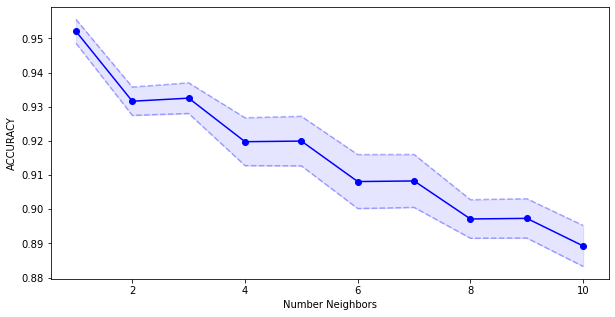

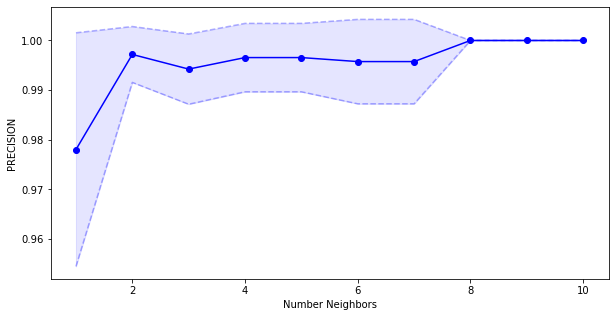

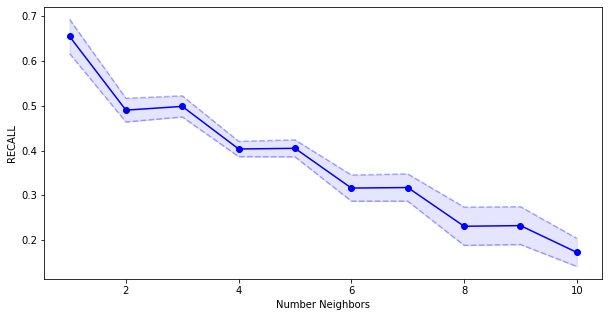

In [14]:
import matplotlib.pyplot as plt

params = list(range(1, 11))
scores = [cross_kfold_score(vectorizer, CustomKNN(n_neighbors=param), X, Y) for param in params]

for name in ['accuracy', 'precision', 'recall']:
    scores_name = np.array([score[name]['score'] for score in scores])
    scores_name_std = np.array([score[name]['std'] for score in scores])
    
    plt.figure(figsize=(10, 5))

    plt.plot(params, scores_name, 'o-', color='b')

    upper = scores_name + scores_name_std
    lower = scores_name - scores_name_std

    plt.plot(params, upper, 'b--', alpha=0.3)
    plt.plot(params, lower, 'b--', alpha=0.3)

    plt.fill_between(params, lower, upper, alpha=0.1, color='b')

    plt.ylabel(name.upper())
    plt.xlabel('Number Neighbors')

    plt.show()

Попробуем улучшить качество модели, поменяв метрику:

In [15]:
class CustomKNN(ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
    
    def fit(self, X, Y):
        self.W = X
        self.classes = Y
        
        return self
        
    def predict(self, X):
        Y = []
        for distances in pairwise_distances(X, self.W, metric=self.metric):
            indexes = np.argpartition(distances, self.n_neighbors)
            indexes = indexes[:self.n_neighbors]
            
            unique, counts = np.unique(self.classes[indexes], return_counts=True)
            
            Y.append(unique[counts.argmax()])
        
        return np.array(Y)

In [16]:
scores_euclidean = [cross_kfold_score(vectorizer, CustomKNN(n_neighbors=param, metric='euclidean'), X, Y) for param in params]
scores_cosine = [cross_kfold_score(vectorizer, CustomKNN(n_neighbors=param, metric='cosine'), X, Y) for param in params]

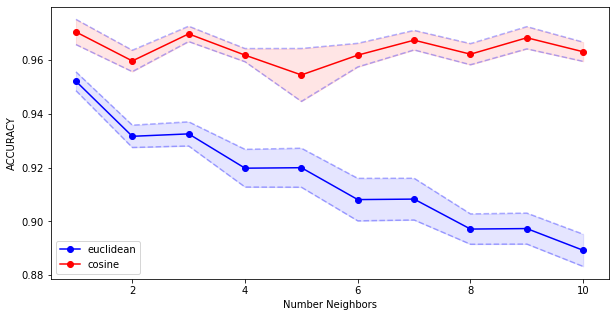

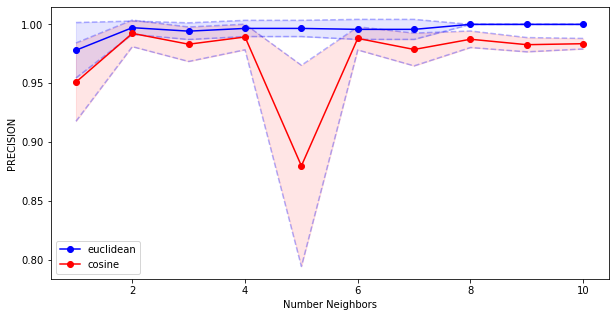

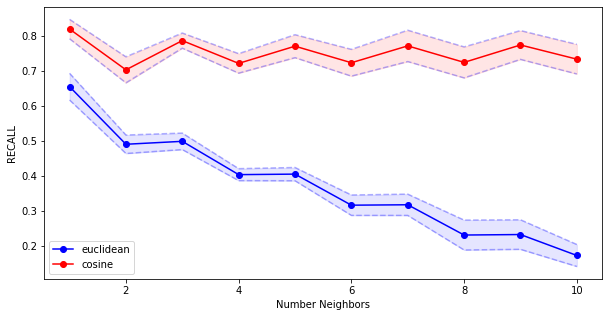

In [17]:
for name in ['accuracy', 'precision', 'recall']:
    plt.figure(figsize=(10, 5))
    
    for metric, scores_metric, color in [('euclidean', scores_euclidean, 'b'), 
                                         ('cosine', scores_cosine, 'r')]:
        scores_name = np.array([score[name]['score'] for score in scores_metric])
        scores_name_std = np.array([score[name]['std'] for score in scores_metric])

        plt.plot(params, scores_name, 'o-', color=color, label=metric)

        upper = scores_name + scores_name_std
        lower = scores_name - scores_name_std

        plt.plot(params, upper, 'b--', alpha=0.3)
        plt.plot(params, lower, 'b--', alpha=0.3)

        plt.fill_between(params, lower, upper, alpha=0.1, color=color)

        plt.ylabel(name.upper())
        plt.xlabel('Number Neighbors')
        
        plt.legend()
        
    plt.show()

In [18]:
print('K-Nearest Neighbours\n')

scores = cross_kfold_score(vectorizer, CustomKNN(n_neighbors=3, metric='cosine'), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

K-Nearest Neighbours

accuracy: 0.96967 (0.002853)
precision: 0.983116 (0.014653)
recall: 0.786593 (0.021645)


In [21]:
print('Logistic Regression\n')

scores = cross_kfold_score(vectorizer, LogisticRegression(), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

Logistic Regression

accuracy: 0.969669 (0.002373)
precision: 0.986835 (0.01088)
recall: 0.783548 (0.015697)


## Using word2vecs 

In [22]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    
    return data

embeddings = load_vectors('wiki-news-300d-1M.vec')

In [44]:
class Word2VecVectorizer(TfidfVectorizer):
    def __init__(self, embeddings, **kwargs):
        super(Word2VecVectorizer, self).__init__(**kwargs)
        
        self.embeddings = embeddings
        
    def fit(self, X):
        TfidfVectorizer.fit(self, X)
        vocabulary = np.array(self.get_feature_names())
        
        self.vocabulary_indexes = [index for index, token in enumerate(vocabulary) if token in self.embeddings]
        self.embedding_vectors = np.array([self.embeddings[token] for token in vocabulary[self.vocabulary_indexes]])
        
        return self
    
    def transform(self, X):
        X = TfidfVectorizer.transform(self, X)
        
        return X[:, self.vocabulary_indexes] @ self.embedding_vectors
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [46]:
vectorizer = Word2VecVectorizer(embeddings, max_df=0.97, min_df=3, stop_words='english')

In [47]:
print('K-Nearest Neighbours\n')

scores = cross_kfold_score(vectorizer, CustomKNN(n_neighbors=3, metric='cosine'), X, Y)
scores = [f'{name}: {round(score["score"], 6)} ({round(score["std"], 6)})' for name, score in scores.items()]

print('\n'.join(scores))

K-Nearest Neighbours

accuracy: 0.976848 (0.002866)
precision: 0.904669 (0.015824)
recall: 0.923527 (0.017184)
